In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns= inspector.get_columns("measurement")
for column in columns:
    print(column["name"],column['type'])
print("--------------")
columns= inspector.get_columns("station")
for column in columns:
    print(column["name"],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Precipitation analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
def precipitation():

    # Calculate the date 1 year ago from the last data point in the database
    lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    lastdate = dt.datetime.strptime(str(lastdate[0]), '%Y-%m-%d')

    # Perform a query to retrieve the data and precipitation scores
    yearago =  lastdate - dt.timedelta(days=365)

    results = session.query(Measurement.date, Measurement.prcp, Measurement.station)\
        .filter(Measurement.date>=yearago).\
        order_by(Measurement.date.asc()).statement

    return results

# Save the query results as a Pandas DataFrame and set the index to the date column
query=precipitation()
df=pd.read_sql_query(query,session.bind)
clean_df=df.dropna()
# Sort the dataframe by date
clean_df=clean_df.set_index("date")
# Use Pandas Plotting with Matplotlib to plot the data
clean_df.head()

,prcp,station
date,,
2016-08-24,0.08,USC00519397
2016-08-24,2.15,USC00513117
2016-08-24,2.28,USC00514830
2016-08-24,1.22,USC00519523
2016-08-24,2.15,USC00519281


In [49]:
clean_df['prcp'].max()

6.7

In [47]:
import matplotlib.dates as mdates

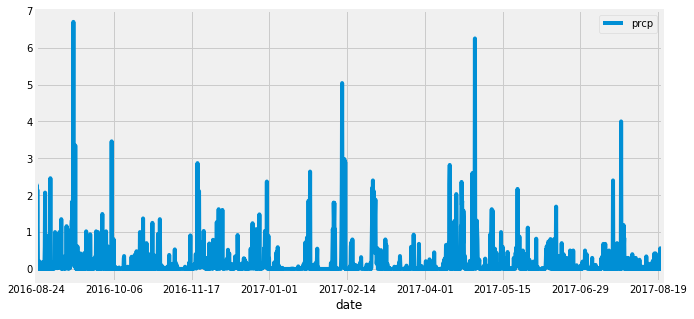

In [55]:
clean_df.plot(figsize=(10,5));
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=20))
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
clean_df["prcp"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# station analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

results = session.query(Measurement.station,).statement
station_df = pd.read_sql_query(results,session.bind)

print(station_df["station"].drop_duplicates().shape[0])
print("--------------")
print(station_df["station"].value_counts())

9
--------------
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
results = session.query(Measurement.station,Measurement.tobs)\
        .filter(Measurement.station=="USC00519281").statement

temp_df=pd.read_sql_query(results,session.bind)
print(temp_df["tobs"].describe())

count    2772.000000
mean       71.663781
std         4.357642
min        54.000000
25%        69.000000
50%        72.000000
75%        74.000000
max        85.000000
Name: tobs, dtype: float64


In [18]:
results = session.query(Measurement.station, Measurement.tobs).statement
station_df = pd.read_sql_query(results,session.bind)
station_df=station_df.dropna()
print(station_df.groupby(station_df["station"]).count())

             tobs
station          
USC00511918  1979
USC00513117  2709
USC00514830  2202
USC00516128  2612
USC00517948  1372
USC00518838   511
USC00519281  2772
USC00519397  2724
USC00519523  2669


In [19]:
# Calculate the date 1 year ago from the last data point in the database
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastdate = dt.datetime.strptime(str(lastdate[0]), '%Y-%m-%d')

yearago =  lastdate - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.tobs, Measurement.station)\
        .filter(Measurement.station=="USC00519281").filter(Measurement.date>=yearago).statement
temp_df = pd.read_sql_query(results,session.bind)
temp_df

,date,tobs,station
0,2016-08-24,77.0,USC00519281
1,2016-08-25,80.0,USC00519281
2,2016-08-26,80.0,USC00519281
3,2016-08-27,75.0,USC00519281
4,2016-08-28,73.0,USC00519281
...,...,...,...
346,2017-08-14,77.0,USC00519281
347,2017-08-15,77.0,USC00519281
348,2017-08-16,76.0,USC00519281
349,2017-08-17,76.0,USC00519281


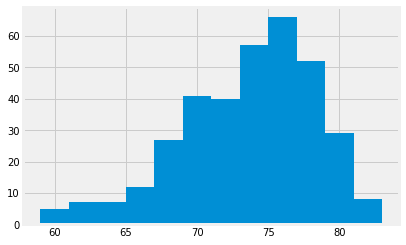

In [20]:
#df=df.loc[df['station'] == "USC00519281"]
hist = temp_df["tobs"].hist(bins=12)

## Optional Challenge Assignment

In [21]:
import pandas as pd
import scipy.stats as stats

# Temperature analysis I

In [22]:
df=pd.read_csv("./Resources/hawaii_measurements.csv")
df["date"]=pd.to_datetime(df["date"])

In [23]:
june_df=df.loc[(df['date'].dt.month == 6)]
december_df=df.loc[(df['date'].dt.month == 12)]

In [24]:
june_df_clean=june_df.dropna()
pop_1=june_df_clean.tobs.mean()
pop_1

74.88754764930114

In [25]:
december_df_clean=december_df.dropna()
pop_2=december_df_clean.tobs.mean()
pop_2

70.93024911032029

In [26]:
print(len(june_df_clean))
print(len(december_df_clean))

1574
1405


In [27]:
# H0: mean of june is equal to mean of december, 
# assume the signifance level is 0.05
# in a t distbruction
# the result p value is too small and so we can reject H0
# this suggest that this is indeed a difference between temperature in June and December 
stats.ttest_ind(june_df_clean['tobs'],december_df_clean['tobs'] , equal_var=False)

Ttest_indResult(statistic=30.624201480767336, pvalue=6.622829250184814e-178)

# Temperature analysis II

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
#trip start date="2019-12-11" end date = '2019-12-17'
t_min,t_mean,t_max=calc_temps('2016-12-11', '2016-12-17')[0]
temp_list=[t_min,t_mean,t_max]
temp_list

[60.0, 68.93333333333334, 78.0]

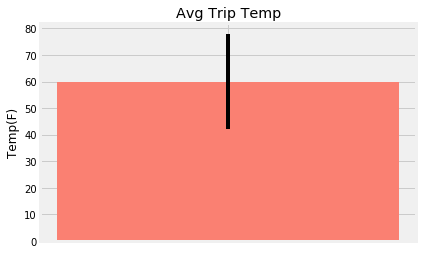

In [30]:
yerr=temp_list[2]-temp_list[0]
plt.bar(1, temp_list[0],yerr=yerr,tick_label='',color='salmon')
plt.ylabel('Temp(F)')
plt.title("Avg Trip Temp")
plt.show()

# Daily Rainfall Average

In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

trip_date=["12-"+str(i) for i in range(11,17+1)]
trip_date

['12-11', '12-12', '12-13', '12-14', '12-15', '12-16', '12-17']

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[daily_normals(j) for j in trip_date]

In [34]:
normals

[[(64.0, 72.38775510204081, 78.0)],
 [(64.0, 70.88235294117646, 79.0)],
 [(65.0, 70.9423076923077, 80.0)],
 [(65.0, 71.18, 78.0)],
 [(62.0, 71.34, 79.0)],
 [(60.0, 69.62264150943396, 82.0)],
 [(63.0, 70.64, 77.0)]]

In [35]:
x=np.reshape(normals,(7,3)).T
x[2]

array([78., 79., 80., 78., 79., 82., 77.])

In [36]:
# Load the previous query results into a Pandas DataFrame 
# and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame({'tmin': x[0], 'tave': x[1],'tmax':x[2]})
trip_df['date'] = trip_date
trip_df.set_index('date', inplace = True)
trip_df

,tmin,tave,tmax
date,,,
12-11,64.0,72.387755,78.0
12-12,64.0,70.882353,79.0
12-13,65.0,70.942308,80.0
12-14,65.0,71.180000,78.0
12-15,62.0,71.340000,79.0
12-16,60.0,69.622642,82.0
12-17,63.0,70.640000,77.0


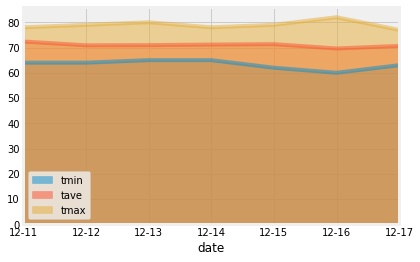

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
plot = trip_df.plot(kind='area',stacked=False)